<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Truck Trailer Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Truck Trailer Problem:* ...                
The problem is inspired from the following paper: [FATROP : A Fast Constrained Optimal Control Problem Solver for Robot Trajectory Optimization and Control](https://arxiv.org/pdf/2303.16746) made for [Casadi](https://web.casadi.org/) software and [Fatrop](https://github.com/meco-group/fatrop) solver.                            
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

## 1. Solving with JuMP <a id='jump'></a>

In [1]:
using JuMP , Ipopt
import HSL_jll
include("../Problems/JuMP/truck_trailer_JMP.jl")
nh=200
TruckJMP = truck_JMP(;nh=nh);

set_optimizer(TruckJMP,Ipopt.Optimizer)
set_attribute(TruckJMP, "print_level", 5)
set_optimizer_attribute(TruckJMP,"tol",1e-8)
set_optimizer_attribute(TruckJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(TruckJMP,"max_iter",1000)
set_optimizer_attribute(TruckJMP,"mu_strategy","adaptive")
set_attribute(TruckJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(TruckJMP, "linear_solver", "ma57")

In [2]:
println("Solving...")
optimize!(TruckJMP)
println()

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    10612
Number of nonzeros in inequality constraint Jacobian.:     2004
Number of nonzeros in Lagrangian Hessian.............:    55005

Total number of variables............................:     1408
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      804
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1010
Total number of inequali

In [ ]:
# Display results
if termination_status(TruckJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(TruckJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(TruckJMP) == MOI.TIME_LIMIT && has_values(TruckJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(TruckJMP))
println()

In [4]:
#state
x2 = TruckJMP[:x2];
y2 = TruckJMP[:y2];
theta0 = TruckJMP[:theta0];
theta1 = TruckJMP[:theta1];
theta2 = TruckJMP[:theta2];
#control 
v0 = TruckJMP[:v0];
delta0 = TruckJMP[:delta0];

#co-state
d_x2 = TruckJMP[:d_x2];
d_y2 = TruckJMP[:d_y2];
d_theta0 = TruckJMP[:d_theta0];
d_theta1 = TruckJMP[:d_theta1];
d_theta2 = TruckJMP[:d_theta2];

tf = value(TruckJMP[:tf])
Δtt = value.(tf)/nh
t = Vector((0:nh)*Δtt); 

p = [ [ dual(d_x2[nh]) , dual(d_y2[nh]) , dual(d_theta0[nh]) , dual(d_theta1[nh]) , dual(d_theta2[nh]) ] ];
p = - [ [[ dual(d_x2[i]), dual(d_y2[i]), dual(d_theta0[i]), dual(d_theta1[i]), dual(d_theta2[i]) ] for i in 1:nh] ; p] ;

x2 = Vector(value.(x2))
y2 = Vector(value.(y2))
theta0 = Vector(value.(theta0))
theta1 = Vector(value.(theta1))
theta2 = Vector(value.(theta2))

v0 = Vector(value.(v0))
delta0 = Vector(value.(delta0))

u = [ [ v0[i], delta0[i]] for i in 1:nh+1] ;

x =  [ [ x2[i], y2[i], theta0[i], theta1[i], theta2[i] ] for i in 1:nh+1] ;


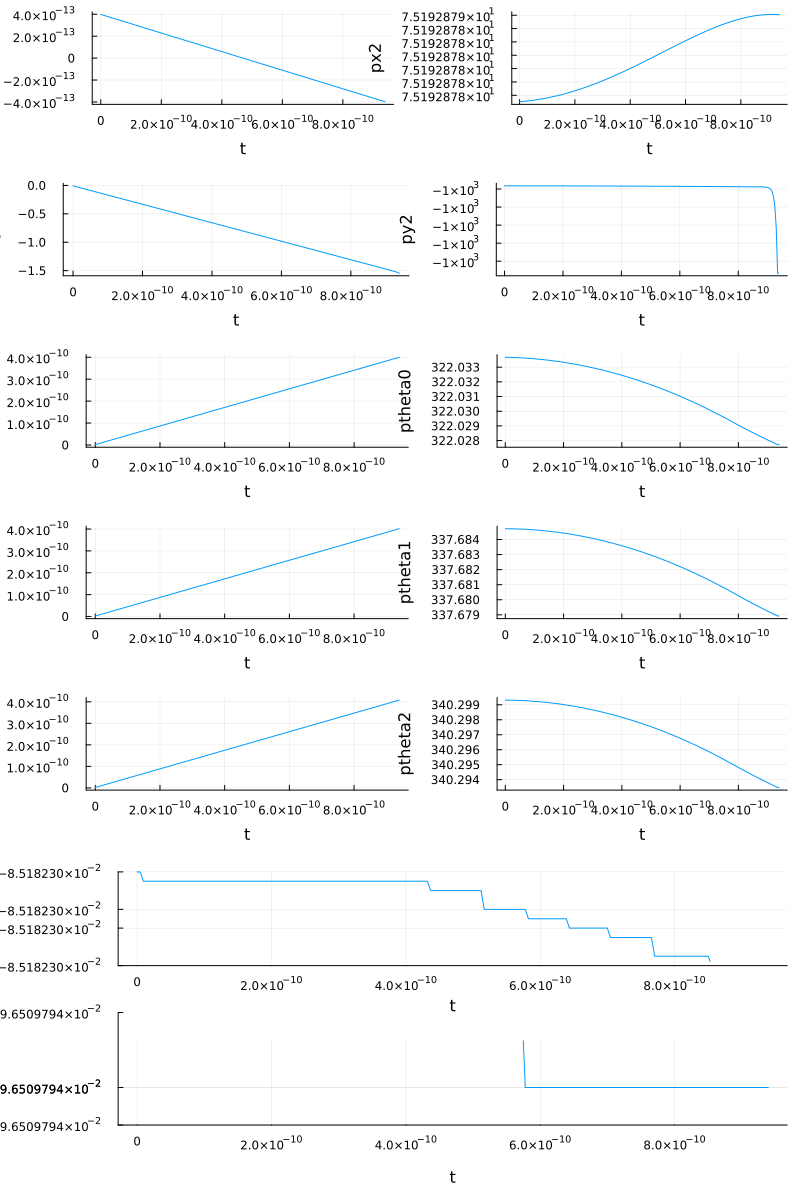

GKS: Possible loss of precision in routine SET_WINDOW


In [5]:
using Plots

x2_plot = plot(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "x2", legend = false)
y2_plot = plot(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "y2", legend = false)
theta0_plot = plot(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta0", legend = false)
theta1_plot = plot(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta1", legend = false)
theta2_plot = plot(t, [ x[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta2", legend = false)
px2_plot = plot(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "px2", legend = false)
py2_plot = plot(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "py2", legend = false)
ptheta0_plot = plot(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta0", legend = false)
ptheta1_plot = plot(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta1", legend = false)
ptheta2_plot = plot(t, [ p[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta2", legend = false)
u1_plot = plot(t, [ u[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "v0", legend = false)
u2_plot = plot(t, [ u[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "delta0", legend = false)

layout = @layout [a b; c d; e f; g h; i j; m; n;]
ploting = plot(x2_plot, px2_plot, y2_plot, py2_plot, theta0_plot, ptheta0_plot, theta1_plot, ptheta1_plot, theta2_plot, ptheta2_plot, u1_plot, u2_plot, layout = layout)
ploting = plot!(ploting, size = (800, 1200))
display(ploting)

## 2. Solving with OptimalControl <a id='oc'></a>

In [6]:
using OptimalControl
include("../Problems/OptimalControl/truck_trailer_OC.jl")
TruckOC = truck_OC();

In [7]:
init =(state=[NaN64,NaN64,0.1,0.0,0.0,-0.2,NaN64]);

In [8]:
import HSL_jll
# Solve the problem
sol = OptimalControl.solve(TruckOC,init=init,
            linear_solver="ma27",hsllib=HSL_jll.libhsl_path)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     7213
Number of nonzeros in inequality constraint Jacobian.:      404
Number of nonzeros in Lagrangian Hessian.............:     2121

Total number of variables............................:     1011
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      606
                     variables with only upper bounds:        0
Total number of equality constraints.................:      811
Total number of inequality constraints...............:      202
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      202
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0000000e-01 2.10e+00 1.00e+00   0.0 0.00e

CTBase.OptimalControlSolution

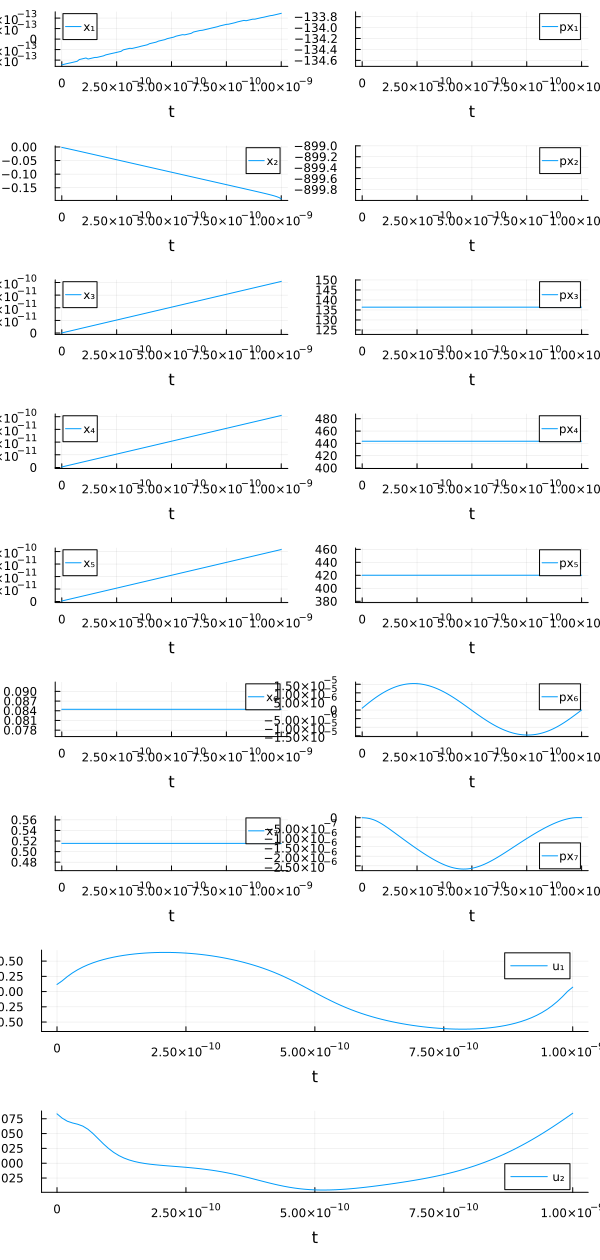

In [9]:
plot(sol)

## 3. Comparison <a id='comp'></a>

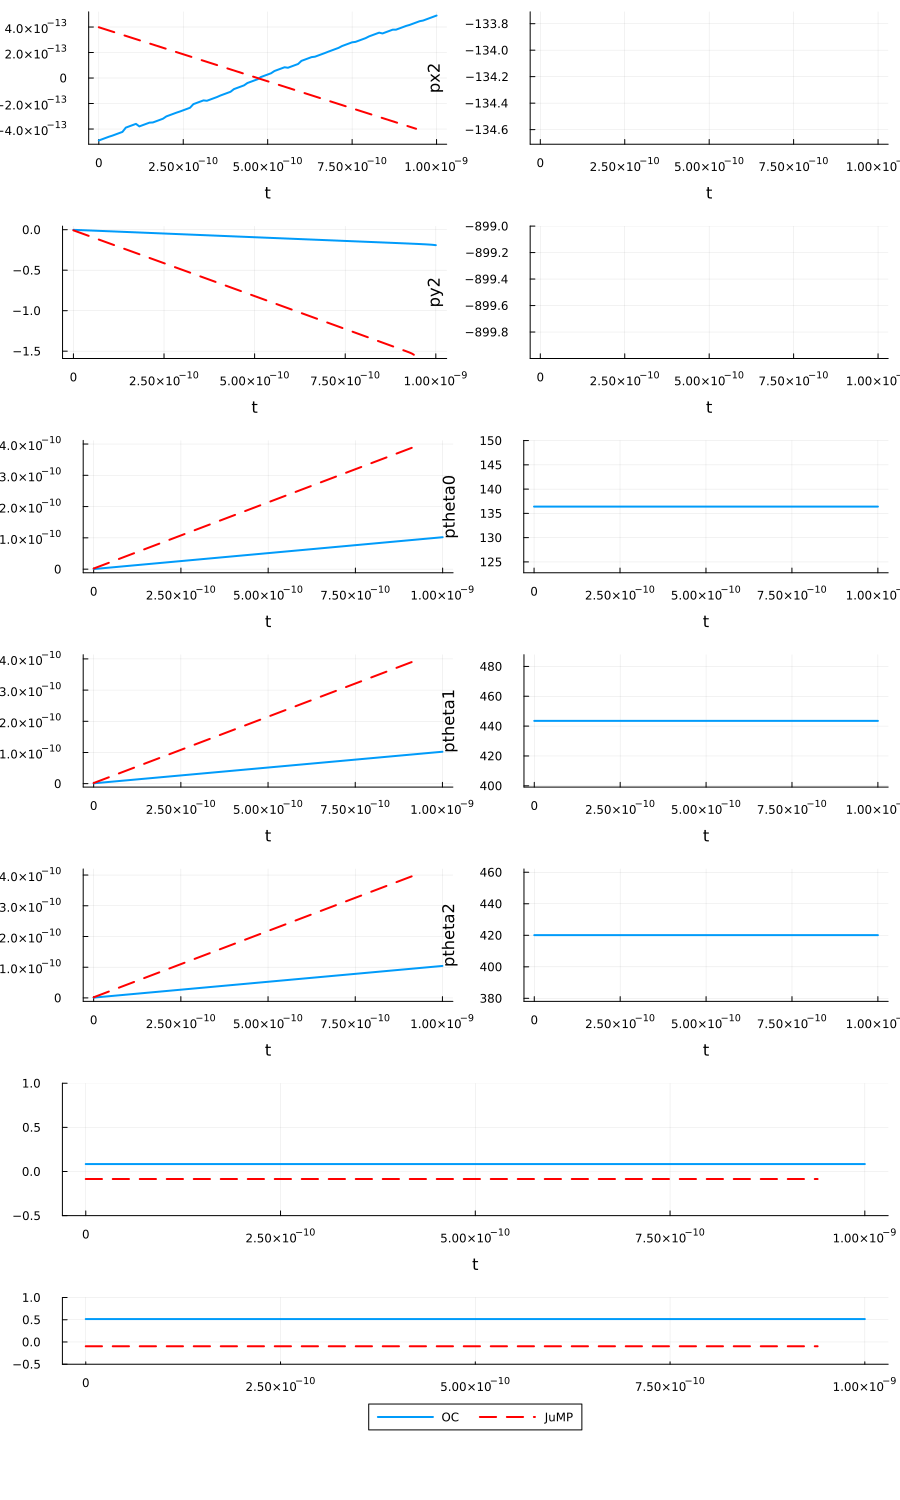

In [13]:
using Plots
p_x2 = plot(plot(sol)[1],line = 2)
p_x2 = plot!(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "x2", legend = false,line = 2, color = "red",linestyle=:dash)

p_y2 = plot(plot(sol)[2],line = 2)
p_y2 = plot!(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "y2", legend = false,line = 2, color = "red",linestyle=:dash)

p_theta0 = plot(plot(sol)[3],line = 2)
p_theta0 = plot!(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta0", legend = false,line = 2, color = "red",linestyle=:dash)

p_theta1 = plot(plot(sol)[4],line = 2)
p_theta1 = plot!(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta1", legend = false,line = 2, color = "red",linestyle=:dash)

p_theta2 = plot(plot(sol)[5],line = 2)
p_theta2 = plot!(t, [ x[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta2", legend = false,line = 2, color = "red",linestyle=:dash)

p_px2 = plot(plot(sol)[8],line = 2)
p_px2 = plot!(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "px2", legend = false,line = 2, color = "red",linestyle=:dash)

p_py2 = plot(plot(sol)[9],line = 2)
p_py2 = plot!(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "py2", legend = false,line = 2, color = "red",linestyle=:dash)

p_ptheta0 = plot(plot(sol)[10],line = 2)
p_ptheta0 = plot!(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta0", legend = false,line = 2, color = "red",linestyle=:dash)

p_ptheta1 = plot(plot(sol)[11],line = 2)
p_ptheta1 = plot!(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta1", legend = false,line = 2, color = "red",linestyle=:dash)

p_pheta2 = plot(plot(sol)[12],line = 2)
p_pheta2 = plot!(t, [ p[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta2", legend = false,line = 2, color = "red",linestyle=:dash)

p_v0 = plot(plot(sol)[6],line = 2,ylim = (-0.5,1))
p_v0 = plot!(t, [ u[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "v0", legend = false,line = 2, color = "red",linestyle=:dash)

p_delta0 = plot(plot(sol)[7], label ="OC",line = 2,ylim = (-0.5,1))
p_delta0 = plot!(t, [ u[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "delta0", legend = false,label = "JuMP",line = 2, color = "red",linestyle=:dash)
p_delta0 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [p_x2 p_px2; p_y2 p_py2; p_theta0 p_ptheta0; p_theta1 p_ptheta1; p_theta2 p_pheta2; p_v0; p_delta0]

x_plot = plot(p_x2, p_px2, p_y2, p_py2, p_theta0, p_ptheta0, p_theta1, p_ptheta1, p_theta2, p_pheta2, p_v0, p_delta0, layout = layout)
x_plot = plot!(size = (900, 1500))

display(x_plot)